In [2]:
import pandas as pd
import numpy as np
import json

In [17]:
# load covid data
ids = []
with open('project-data/covid.data.txt') as f:
    for line in f.readlines():
        ids.append(line.rstrip('\n').split(','))

covidData = []
for thread in ids:
    try:
        # proceed only if the source tweet exists
        with open('project-data/covid_objs/' + thread[0] + '.json') as json_file:
            source = json.load(json_file)['text']
        covidData.append(source)
    except:
        covidData.append('')
        continue

In [31]:
# load predicted labels
empty_tweet_index = pd.read_csv("project-data/covid_removed_index.csv")['predicted_index'].values
predicted_index = [ind for ind in range(len(covidData)) if ind not in empty_tweet_index ]
labels = pd.read_csv("project-data/covid_predictions.csv")['labels'].values

# store rumours and non-rumours seperately
rumours = []
nonrumours = []
for ind, label in zip(predicted_index, labels):
    if label == 0:
        nonrumours.append(covidData[ind])
    else:
        rumours.append(covidData[ind])

## Popular Hashtags of rumours and non-rumours

In [32]:
# tokenizer
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()

def get_hashtags(data):
    hashtags = []
    for tweet in data:
        for word in tt.tokenize(tweet):
            if word.startswith("#") and len(word) > 1:
                hashtags.append(word)
    return hashtags
rumours_hashtags = get_hashtags(rumours)
nonrumours_hashtags = get_hashtags(nonrumours)

In [33]:
from collections import Counter
print('rumour hashtags: {}'.format(Counter(rumours_hashtags).most_common(10)))
print('non-rumour hashtags: {}'.format(Counter(nonrumours_hashtags).most_common(10)))

rumour hashtags: [('#COVID19', 67), ('#coronavirus', 39), ('#Coronavirus', 10), ('#Trump', 7), ('#covid19', 6), ('#China', 6), ('#BREAKING', 4), ('#Covid19', 3), ('#BlackLivesMatter', 3), ('#TrumpPressConference', 2)]
non-rumour hashtags: [('#COVID19', 1031), ('#coronavirus', 427), ('#Coronavirus', 109), ('#Covid19', 85), ('#BREAKING', 84), ('#covid19', 58), ('#CoronaVirus', 24), ('#China', 19), ('#lockdown', 15), ('#StayHome', 14)]


## Sentiment of rumours and non-rumours

In [35]:
# preprocess tweets
import preprocessor as p
p.set_options(p.OPT.URL, p.OPT.MENTION)

tidy_rumours = [p.clean(tweet) for tweet in rumours]
tidy_nonrumours = [p.clean(tweet) for tweet in nonrumours]

In [36]:
from textblob import TextBlob

def get_attidude(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

def sentiment(tweets):
    polarity_scores = [TextBlob(t).sentiment.polarity for t in tweets]
    attitudes = [get_attidude(s) for s in polarity_scores]
    return attitudes

rumour_sentiments = sentiment(tidy_rumours)
nonrumour_sentiments = sentiment(tidy_nonrumours)

rumour_sa_counts = Counter(rumour_sentiments)
nonrumour_sa_counts = Counter(nonrumour_sentiments)

print('rumour sentiments: {}'.format(Counter(rumour_sa_counts)))
print('non-rumour sentiments: {}'.format(Counter(nonrumour_sa_counts)))

rumour sentiments: Counter({'neutral': 1144, 'positive': 780, 'negative': 644})
non-rumour sentiments: Counter({'neutral': 5674, 'positive': 5380, 'negative': 2340})


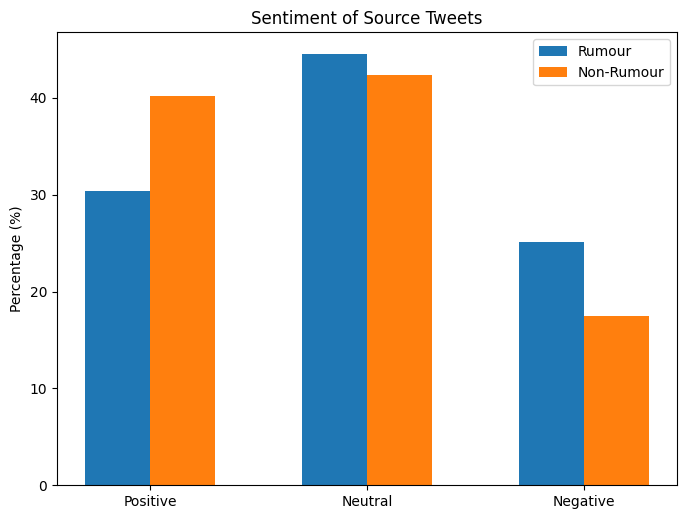

In [48]:
import matplotlib.pyplot as plt

# data preparation
def sentiment_percentage(labels):
    counts = Counter(labels)
    neg = counts['negative']
    pos = counts['positive']
    neu = counts['neutral']
    s = len(labels)
    return np.round(np.array([pos, neu, neg])/s*100, 2)

rumour_sa_pctg = sentiment_percentage(rumour_sentiments)
nonrumour_sa_pctg = sentiment_percentage(nonrumour_sentiments)

plt.figure(figsize=(8,6), dpi=100)

width = 0.3
ind = np.arange(3)

plt.bar(ind, rumour_sa_pctg, width, label='Rumour')
plt.bar(ind + width, nonrumour_sa_pctg, width, label='Non-Rumour')

plt.title('Sentiment of Source Tweets')
plt.ylabel('Percentage (%)')

plt.xticks(ind + width / 2, ('Positive', 'Neutral', 'Negative'))

plt.legend(loc='best')
plt.savefig('sentiment.png', bbox_inches='tight')
plt.show()

In [47]:
plt.savefig('sentiment.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>